# Track Objects

Let's build on the last perception example and work to integrate longitudinal scenes with a tracker. AVtack provides a few custom tracking implementations with inspiration taken from some literature examples.

In [1]:
import os
import avstack
import avapi
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

data_base = '../../lib-avstack-api/data/'
obj_data_dir_k = os.path.join(data_base, 'KITTI/object')
raw_data_dir_k = os.path.join(data_base, 'KITTI/raw')
obj_data_dir_c = os.path.join(data_base, 'CARLA/carla-object-v1')

KSM = avapi.kitti.KittiScenesManager(obj_data_dir_k, raw_data_dir_k, convert_raw=False)
KDM = KSM.get_scene_dataset_by_index(scene_idx=0)

DM = KDM  # let's use kitti for this one

Cannot import rss library
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LiDAR-Based Perception and Tracking

Ensure that you have the perception model weights downloaded. Following the installation instructions from the last tutorial should do the job.

In [2]:
result_folder = 'results_lidar'
P = avstack.modules.perception.object3d.MMDetObjectDetector3D(
        model='pointpillars', dataset='kitti', threshold=0.7, 
        save_output=True, save_folder=result_folder)
T = avstack.modules.tracking.tracker3d.BasicBoxTracker3D(
        framerate=DM.framerate, save_output=True, save_folder=result_folder)

Overriding default threshold of 0.5 with 0.7


/home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:92: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/checkpoints/kitti/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class_20220301_150306-37dc2420.pth


### Inference over Sequence

In [3]:
# detection and tracking
for frame in tqdm(DM.frames):
    pc = DM.get_lidar(frame, sensor='main_lidar')
    timestamp = DM.framerate * frame
    
    # -- perception
    dets = P(pc, frame=frame, identifier='lidar-detections')
    
    # -- tracking
    tracks = T(detections_nd=dets, t=timestamp, frame=frame)

  0%|                                                                            | 0/108 [00:00<?, ?it/s]/home/spencer/.cache/pypoetry/virtualenvs/avstack-docs-l0eE3ZqO-py3.8/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████████████████████████████████████████████████████████████| 108/108 [00:04<00:00, 22.78it/s]


### Evaluation

Evaluation can be accelerated using multiprocessing - this is enabled by default in the following commands. Evaluation over a sequence outputs both per-frame metrics and also aggregates these metrics over the entire sequence.

In [4]:
%%capture
# ^^ suppress output
percep_res_frames, percep_res_seq, _ = avapi.evaluation.get_percep_results_from_folder(
    DM, P.save_folder, sensor_eval='main_lidar')
track_res_frames, track_res_seq, track_res_exp = avapi.evaluation.get_track_results_from_folder(
    DM, T.save_folder, sensor_eval='main_lidar')

In [5]:
print('Aggregate perception results:\n', percep_res_seq, '\n')
print('Aggregate tracking results:\n', track_res_seq, '\n')
print('Expanded track metrics include:\n', track_res_exp.keys(), '\n')
print(f'     e.g., HOTA_LocA(0): {track_res_exp["HOTA_LocA(0)"]}')

Aggregate perception results:
 {'tot_TP': 340, 'tot_FP': 78, 'tot_FN': 110, 'tot_T': 450, 'mean_precision': 0.8159391534391536, 'mean_recall': 0.7542989417989419} 

Aggregate tracking results:
 {'tot_TT': 324, 'tot_FT': 95, 'tot_MT': 126, 'tot_T': 450, 'mean_precision': 0.7644841269841272, 'mean_recall': 0.7238977072310406} 

Expanded track metrics include:
 dict_keys(['HOTA_HOTA', 'HOTA_DetA', 'HOTA_AssA', 'HOTA_DetRe', 'HOTA_DetPr', 'HOTA_AssRe', 'HOTA_AssPr', 'HOTA_LocA', 'HOTA_OWTA', 'HOTA_HOTA_TP', 'HOTA_HOTA_FN', 'HOTA_HOTA_FP', 'HOTA_HOTA(0)', 'HOTA_LocA(0)', 'HOTA_HOTALocA(0)', 'CLEAR_MOTA', 'CLEAR_MOTP', 'CLEAR_MODA', 'CLEAR_CLR_Re', 'CLEAR_CLR_Pr', 'CLEAR_MTR', 'CLEAR_PTR', 'CLEAR_MLR', 'CLEAR_sMOTA', 'CLEAR_CLR_F1', 'CLEAR_FP_per_frame', 'CLEAR_MOTAL', 'CLEAR_MOTP_sum', 'CLEAR_CLR_TP', 'CLEAR_CLR_FN', 'CLEAR_CLR_FP', 'CLEAR_IDSW', 'CLEAR_MT', 'CLEAR_PT', 'CLEAR_ML', 'CLEAR_Frag', 'CLEAR_CLR_Frames', 'VACE_STDA', 'VACE_VACE_IDs', 'VACE_VACE_GT_IDs', 'VACE_FDA', 'VACE_num_non_

### Visualization

We can visualize the tracking results by creating a movie.

<IPython.core.display.Javascript object>


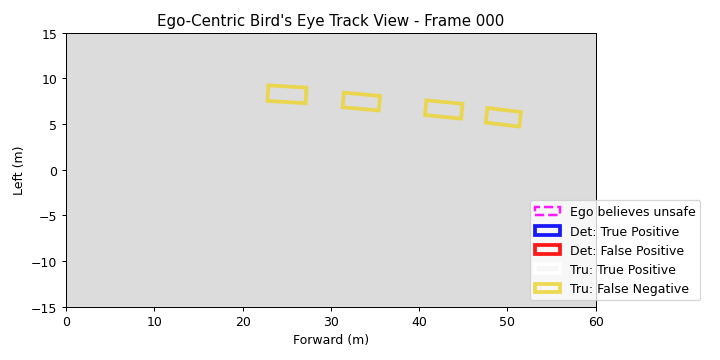

interactive(children=(IntSlider(value=0, description='idx', max=107), Output()), _dom_classes=('widget-interac…

In [6]:
%matplotlib notebook
avapi.visualize.replay.replay_track_results(track_res_frames, fig_width=8)

TODO: fix the bottom vs. center discrepancy on the plotting

<IPython.core.display.Javascript object>


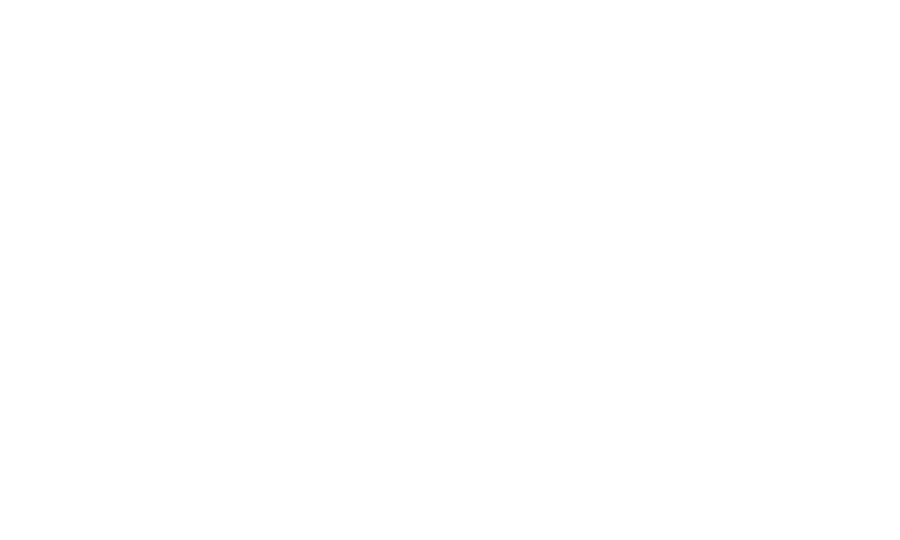

interactive(children=(IntSlider(value=0, description='idx', max=107), Output()), _dom_classes=('widget-interac…

In [7]:
%matplotlib notebook
avapi.visualize.replay.replay_track_percep_results(DM, track_res_frames, figsize=(10,6))

## Camera-LiDAR Fusion at the Tracking Level

Notice how the precision metric is greatly improved using camera-lidar fusion as opposed to lidar-based tracking alone!

In [10]:
result_folder = 'results_fusion'

P_cam = avstack.modules.perception.object2dfv.MMDetObjectDetector2D(
        model='fasterrcnn', dataset='kitti', threshold=0.7, gpu=0,
        save_output=True, save_folder=result_folder)


P_lid = avstack.modules.perception.object3d.MMDetObjectDetector3D(
        model='pointpillars', dataset='kitti', threshold=0.7, gpu=0,
        save_output=True, save_folder=result_folder)


T_fuse = avstack.modules.tracking.tracker3d.BasicBoxTrackerFusion3Stage(
        framerate=DM.framerate, save_output=True, save_folder=result_folder)

Overriding default threshold of 0.5 with 0.7
Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection/checkpoints/cityscapes/faster_rcnn_r50_fpn_1x_cityscapes_20200502-829424c0.pth
Overriding default threshold of 0.5 with 0.7
Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/checkpoints/kitti/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class_20220301_150306-37dc2420.pth


/home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:92: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


### Inference over Sequence

In [12]:
# detection and tracking
for frame in tqdm(DM.frames):
    timestamp = DM.framerate * frame
    pc = DM.get_lidar(frame, sensor='main_lidar')
    img = DM.get_image(frame, sensor='main_camera')
    
    # -- perception
    dets_lid = P_lid(pc, frame=frame, identifier='lidar-detections')
    dets_cam = P_cam(img, frame=frame, identifier='camera-detections')
    
    # -- tracking
    tracks = T_fuse(detections_3d=dets_lid, detections_2d=dets_cam, t=timestamp, frame=frame)

100%|██████████████████████████████████████████████████████████████████| 108/108 [00:10<00:00, 10.13it/s]


### Evaluation

In [13]:
%%capture
# ^^ suppress output
percep_res_frames, percep_res_seq, _ = avapi.evaluation.get_percep_results_from_folder(
    DM, P_lid.save_folder, sensor_eval='main_lidar')
track_res_frames, track_res_seq, track_res_exp = avapi.evaluation.get_track_results_from_folder(
    DM, T_fuse.save_folder, sensor_eval='main_lidar')

In [14]:
print('Aggregate perception results:\n', percep_res_seq, '\n')
print('Aggregate tracking results:\n', track_res_seq, '\n')
print('Expanded track metrics include:\n', track_res_exp.keys(), '\n')
print(f'     e.g., HOTA_LocA(0): {track_res_exp["HOTA_LocA(0)"]}')

Aggregate perception results:
 {'tot_TP': 340, 'tot_FP': 78, 'tot_FN': 110, 'tot_T': 450, 'mean_precision': 0.8159391534391536, 'mean_recall': 0.7542989417989419} 

Aggregate tracking results:
 {'tot_TT': 239, 'tot_FT': 16, 'tot_MT': 211, 'tot_T': 450, 'mean_precision': 0.6603395061728394, 'mean_recall': 0.485626102292769} 

Expanded track metrics include:
 dict_keys(['HOTA_HOTA', 'HOTA_DetA', 'HOTA_AssA', 'HOTA_DetRe', 'HOTA_DetPr', 'HOTA_AssRe', 'HOTA_AssPr', 'HOTA_LocA', 'HOTA_OWTA', 'HOTA_HOTA_TP', 'HOTA_HOTA_FN', 'HOTA_HOTA_FP', 'HOTA_HOTA(0)', 'HOTA_LocA(0)', 'HOTA_HOTALocA(0)', 'CLEAR_MOTA', 'CLEAR_MOTP', 'CLEAR_MODA', 'CLEAR_CLR_Re', 'CLEAR_CLR_Pr', 'CLEAR_MTR', 'CLEAR_PTR', 'CLEAR_MLR', 'CLEAR_sMOTA', 'CLEAR_CLR_F1', 'CLEAR_FP_per_frame', 'CLEAR_MOTAL', 'CLEAR_MOTP_sum', 'CLEAR_CLR_TP', 'CLEAR_CLR_FN', 'CLEAR_CLR_FP', 'CLEAR_IDSW', 'CLEAR_MT', 'CLEAR_PT', 'CLEAR_ML', 'CLEAR_Frag', 'CLEAR_CLR_Frames', 'VACE_STDA', 'VACE_VACE_IDs', 'VACE_VACE_GT_IDs', 'VACE_FDA', 'VACE_num_non_e

### Visualization

<IPython.core.display.Javascript object>


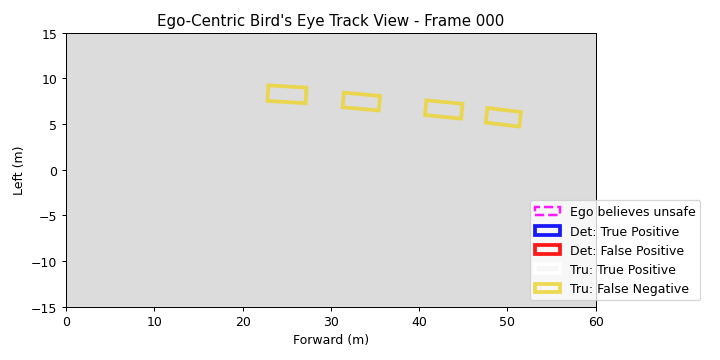

interactive(children=(IntSlider(value=0, description='idx', max=107), Output()), _dom_classes=('widget-interac…

In [15]:
%matplotlib notebook
avapi.visualize.replay.replay_track_results(track_res_frames, fig_width=8)

<IPython.core.display.Javascript object>


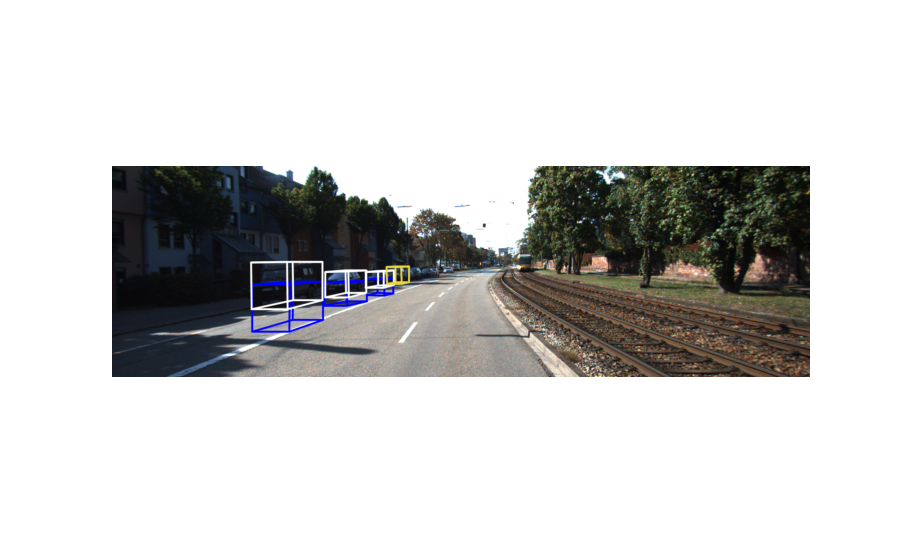

interactive(children=(IntSlider(value=0, description='idx', max=107), Output()), _dom_classes=('widget-interac…

In [16]:
%matplotlib notebook
avapi.visualize.replay.replay_track_percep_results(DM, track_res_frames, figsize=(10,6))